In [3]:
# Célula 1: --- Importações e Preparação do Dataset ---

# IMPORTAÇÕES E CONFIGURAÇÃO
import os
import shutil
import tarfile
import requests
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

print("TensorFlow Versão:", tf.__version__)

# Configurações globais
IMG_SIZE = (256, 256)
BATCH_SIZE = 16
DATASET_PATH = "content"
CATEGORY = "bottle"
ARCHIVE_NAME = "bottle.tar.xz"

# Link do dataset
DATASET_URL = "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f283/download/420937370-1629958698/bottle.tar.xz"
archive_path = os.path.join(DATASET_PATH, ARCHIVE_NAME)

# DOWNLOAD E EXTRAÇÃO DO DATASET
if not os.path.exists(DATASET_PATH):
    os.makedirs(DATASET_PATH)

if not os.path.exists(os.path.join(DATASET_PATH, CATEGORY)):
    print(f"Dataset '{CATEGORY}' não encontrado.")

    if not os.path.exists(archive_path):
        print(f"Arquivo '{ARCHIVE_NAME}' não encontrado. Baixando de {DATASET_URL}...")
        try:
            with requests.get(DATASET_URL, stream=True) as r:
                r.raise_for_status()
                with open(archive_path, 'wb') as f:
                    for chunk in r.iter_content(chunk_size=8192):
                        f.write(chunk)
            print("Download concluído.")
        except requests.exceptions.RequestException as e:
            print(f"Erro ao baixar o arquivo: {e}")

    try:
        print(f"Extraindo arquivos de '{archive_path}' para '{DATASET_PATH}'...")
        with tarfile.open(archive_path, 'r:xz') as tar:
            tar.extractall(path=DATASET_PATH)
        print("Dataset extraído com sucesso.")
    except Exception as e:
        print(f"Ocorreu um erro durante a extração: {e}")

else:
    print(f"Dataset '{CATEGORY}' já existe no diretório '{DATASET_PATH}'.")


# DEFINIÇÃO DOS CAMINHOS
base_dir = os.path.join(DATASET_PATH, CATEGORY)
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

print(f"\nCaminho para dados de treino: {train_dir}")
print(f"Caminho para dados de teste: {test_dir}")

TensorFlow Versão: 2.19.0
Dataset 'bottle' não encontrado.
Arquivo 'bottle.tar.xz' não encontrado. Baixando de https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f283/download/420937370-1629958698/bottle.tar.xz...
Download concluído.
Extraindo arquivos de 'content/bottle.tar.xz' para 'content'...


/tmp/ipython-input-2168330014.py:50: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=DATASET_PATH)


Dataset extraído com sucesso.

Caminho para dados de treino: content/bottle/train
Caminho para dados de teste: content/bottle/test


In [4]:
# Célula 2: --- Importa a função de pré-processamento específica do ResNet50 ---
from tensorflow.keras.applications.resnet50 import preprocess_input


datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2  # 20% dos dados de treino para validação
)

# Carregador para os dados de TREINO (80% das imagens 'good')
train_generator = datagen.flow_from_directory(
    directory=train_dir,
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode='input',
    subset='training',
    shuffle=True
)

# Carregador para os dados de VALIDAÇÃO (20% das imagens 'good')
validation_generator = datagen.flow_from_directory(
    directory=train_dir,
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode='input',
    subset='validation',
    shuffle=False
)

# Carregador para os dados de TESTE

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=1,
    class_mode='input',
    shuffle=False
)

print("\nDados prontos para o treinamento, validação e teste.")

Found 168 images belonging to 1 classes.
Found 41 images belonging to 1 classes.
Found 83 images belonging to 4 classes.

Dados prontos para o treinamento, validação e teste.


In [5]:
# Célula 3: --- Definição do Extrator de Features (ResNet50) ---
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
import numpy as np

# Carregar uma rede pré-treinada ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# A medotodologia do PaDiM usa as saídas dos 3 primeiros blocos.
layer_names = ['conv2_block3_out', 'conv3_block4_out', 'conv4_block6_out']
outputs = [base_model.get_layer(name).output for name in layer_names]


feature_extractor = Model(inputs=base_model.input, outputs=outputs)

# Congelar o modelo, pois não vamos treiná-lo.
feature_extractor.trainable = False

print("Extrator de features (ResNet50 com 3 blocos) pronto.")
feature_extractor.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Extrator de features (ResNet50 com 3 blocos) pronto.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 8,589,184 (32.77 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 8,589,184 (32.77 MB)

In [6]:
# Célula 4: --- Treinamento: Aprendendo a Distribuição Normal ---
from scipy.spatial.distance import mahalanobis
import numpy as np
from tqdm import tqdm

train_generator.reset()

feature_map_size = (64, 64)
features_list = []

print(f"\nExtraindo features das {train_generator.n} imagens de treino...")

for i in tqdm(range(len(train_generator))):
    x, _ = next(train_generator)

    layer1_features, layer2_features, layer3_features = feature_extractor.predict(x, verbose=0)
    layer2_resized = tf.image.resize(layer2_features, feature_map_size, method='bilinear')
    layer3_resized = tf.image.resize(layer3_features, feature_map_size, method='bilinear')

    combined_features = np.concatenate([layer1_features, layer2_resized, layer3_resized], axis=-1)

    features_list.append(combined_features)

features_stack = np.concatenate(features_list, axis=0)

embedding_dims = 100 # Hiperparâmetro
total_dims = features_stack.shape[-1]
idx = np.random.choice(total_dims, embedding_dims, replace=False)
features_reduced = features_stack[:, :, :, idx]

print("\nCalculando média e matriz de covariância para cada patch...")

features_reduced_T = features_reduced.transpose(1, 2, 0, 3)

mean_embeddings = np.mean(features_reduced_T, axis=2)

covariance = np.zeros((feature_map_size[0], feature_map_size[1], embedding_dims, embedding_dims))
identity = np.identity(embedding_dims)
epsilon = 0.01

for h in tqdm(range(feature_map_size[0])):
    for w in range(feature_map_size[1]):
        features_for_patch = features_reduced_T[h, w, :, :]
        cov = np.cov(features_for_patch, rowvar=False) + epsilon * identity
        covariance[h, w, :, :] = cov

print("\n'Treinamento' concluído. Média e covariância aprendidas.")


Extraindo features das 168 imagens de treino...


100%|██████████| 11/11 [00:21<00:00,  1.92s/it]



Calculando média e matriz de covariância para cada patch...


100%|██████████| 64/64 [00:04<00:00, 13.19it/s]


'Treinamento' concluído. Média e covariância aprendidas.



Calculando scores de anomalia para o conjunto de teste...


100%|██████████| 83/83 [01:27<00:00,  1.05s/it]


Cálculo de scores concluído.

Área Sob a Curva ROC (AUC-ROC): 1.0000


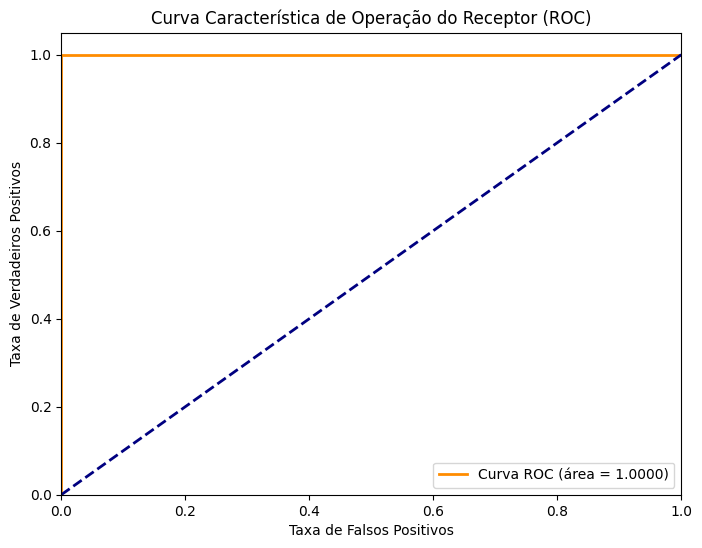

In [7]:
# Célula 5: --- Avaliação Geral via AUC-ROC ---
from sklearn.metrics import roc_curve, auc
from scipy.ndimage import gaussian_filter
from scipy.spatial.distance import mahalanobis
import matplotlib.pyplot as plt

# 1. Cálculo do Score de Anomalia para o Conjunto de Teste
test_generator.reset()
anomaly_scores = []
y_true = (test_generator.classes != test_generator.class_indices['good']).astype(int)

# Definir class_names para o relatório de classificação e matriz de confusão
class_names = ['good', 'anomaly']

print("\nCalculando scores de anomalia para o conjunto de teste...")

if 'anomaly_scores' not in locals() or len(anomaly_scores) != len(y_true):
    for i in tqdm(range(len(test_generator))):
        x_test, _ = test_generator[i]
        # ... (código de extração de features e cálculo da distância de Mahalanobis) ...
        # (Este bloco de código interno do loop permanece o mesmo)
        layer1_test, layer2_test, layer3_test = feature_extractor.predict(x_test, verbose=0)
        layer2_test_resized = tf.image.resize(layer2_test, feature_map_size, method='bilinear')
        layer3_test_resized = tf.image.resize(layer3_test, feature_map_size, method='bilinear')
        combined_features_test = np.concatenate([layer1_test, layer2_test_resized, layer3_test_resized], axis=-1)
        features_test_reduced = combined_features_test[:, :, :, idx]
        anomaly_map = np.zeros((feature_map_size[0], feature_map_size[1]))
        for h in range(feature_map_size[0]):
            for w in range(feature_map_size[1]):
                feature_vec = features_test_reduced[0, h, w]
                mean_vec = mean_embeddings[h, w]
                cov_mat = covariance[h, w]
                try:
                    L = np.linalg.cholesky(cov_mat)
                    y = np.linalg.solve(L, feature_vec - mean_vec)
                    dist = np.sqrt(np.dot(y, y))
                except np.linalg.LinAlgError:
                    dist = mahalanobis(feature_vec, mean_vec, np.linalg.pinv(cov_mat))
                anomaly_map[h, w] = dist
        anomaly_map_smoothed = gaussian_filter(anomaly_map, sigma=4)
        anomaly_scores.append(np.max(anomaly_map_smoothed))
    anomaly_scores = np.array(anomaly_scores)
    print("Cálculo de scores concluído.")

# --- Métrica Independente de Limiar (AUC-ROC) ---
fpr, tpr, _ = roc_curve(y_true, anomaly_scores)
roc_auc = auc(fpr, tpr)
print(f"\nÁrea Sob a Curva ROC (AUC-ROC): {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva Característica de Operação do Receptor (ROC)')
plt.legend(loc="lower right")
plt.show()

Melhor F1-Score encontrado: 1.0000
Limiar correspondente: 19.7032

--- Métricas Baseadas no Limiar Otimizado ---

Relatório de Classificação Otimizado:

              precision    recall  f1-score   support

        good       0.95      1.00      0.98        20
     anomaly       1.00      0.98      0.99        63

    accuracy                           0.99        83
   macro avg       0.98      0.99      0.98        83
weighted avg       0.99      0.99      0.99        83


Matriz de Confusão Otimizada:


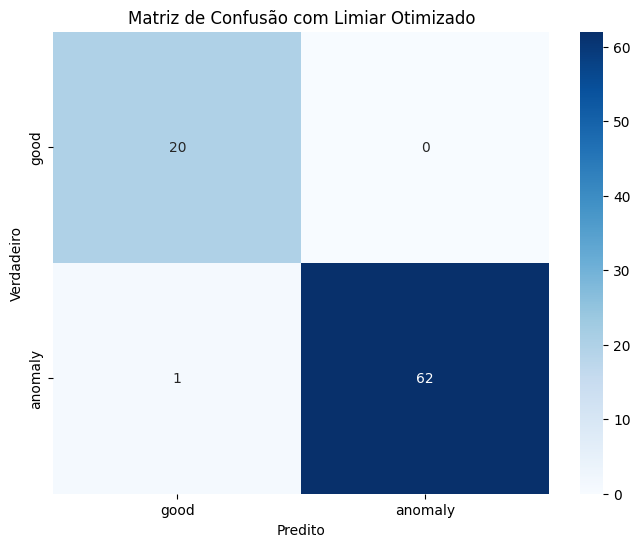

In [8]:
# Célula 6: --- Otimização do Limiar e Métricas Finais ---

from sklearn.metrics import f1_score, precision_recall_curve, classification_report, confusion_matrix
import seaborn as sns


# Calcular o F1-score para cada limiar
precision, recall, thresholds = precision_recall_curve(y_true, anomaly_scores)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
f1_scores = f1_scores[:-1]
thresholds = thresholds[:len(f1_scores)]

# Encontrar o melhor F1-score e o limiar correspondente
best_f1_idx = np.argmax(f1_scores)
best_f1 = f1_scores[best_f1_idx]
best_threshold = thresholds[best_f1_idx]

print(f"Melhor F1-Score encontrado: {best_f1:.4f}")
print(f"Limiar correspondente: {best_threshold:.4f}")

# --- REAVALIAR COM O LIMIAR OTIMIZADO ---
y_pred_best = (anomaly_scores > best_threshold).astype(int)

print("\n--- Métricas Baseadas no Limiar Otimizado ---\n")
print("Relatório de Classificação Otimizado:\n")
print(classification_report(y_true, y_pred_best, target_names=class_names))

print("\nMatriz de Confusão Otimizada:")
cm_best = confusion_matrix(y_true, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão com Limiar Otimizado')
plt.show()


Visualizando 6 mapas de anomalia (3 da classe 'good' e 3 de anomalias):



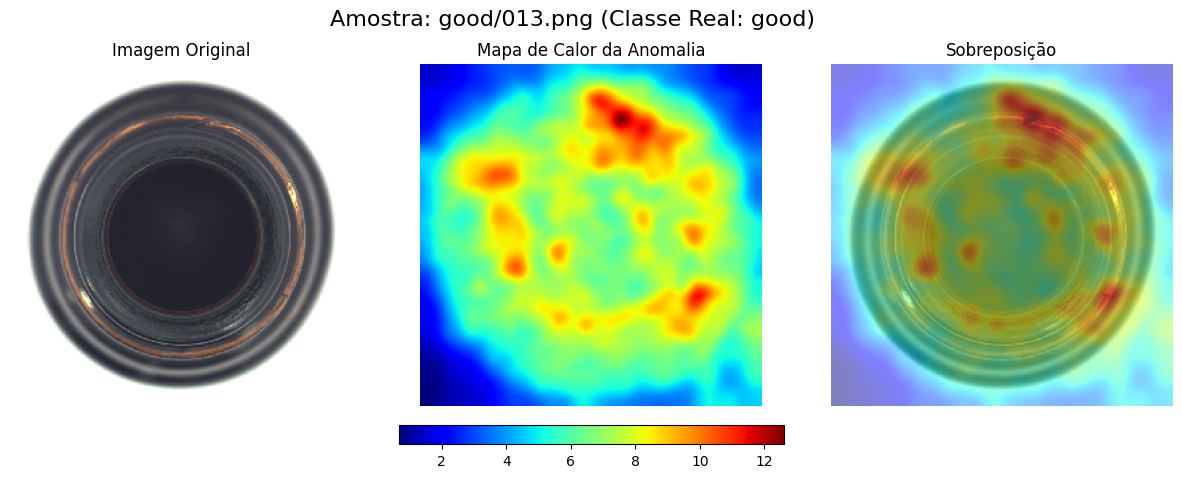

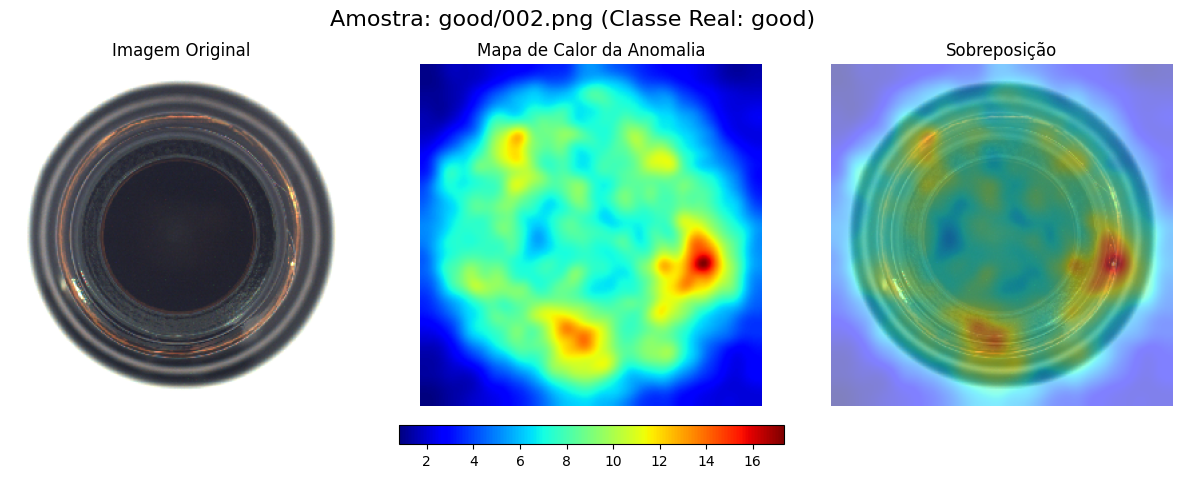

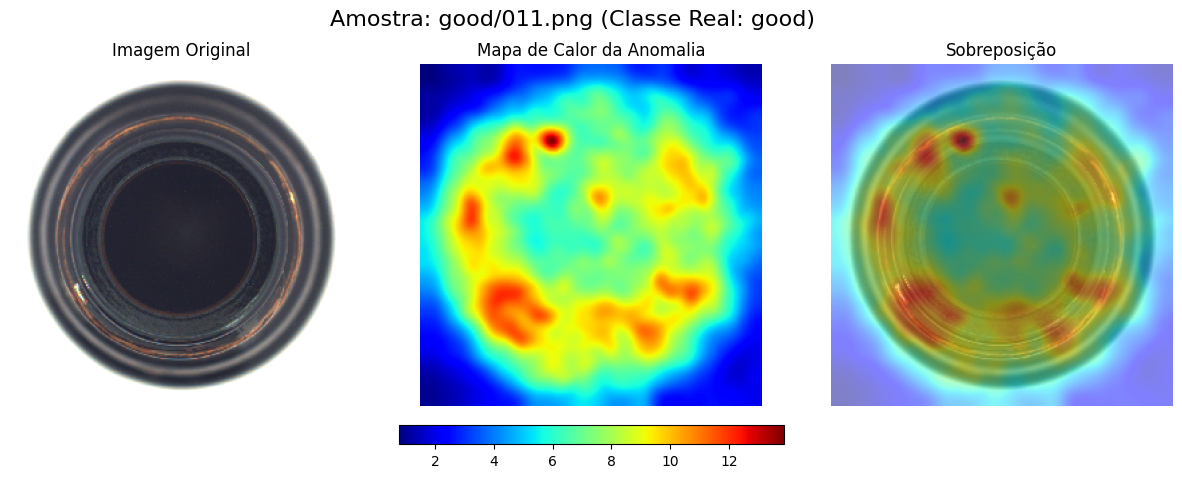

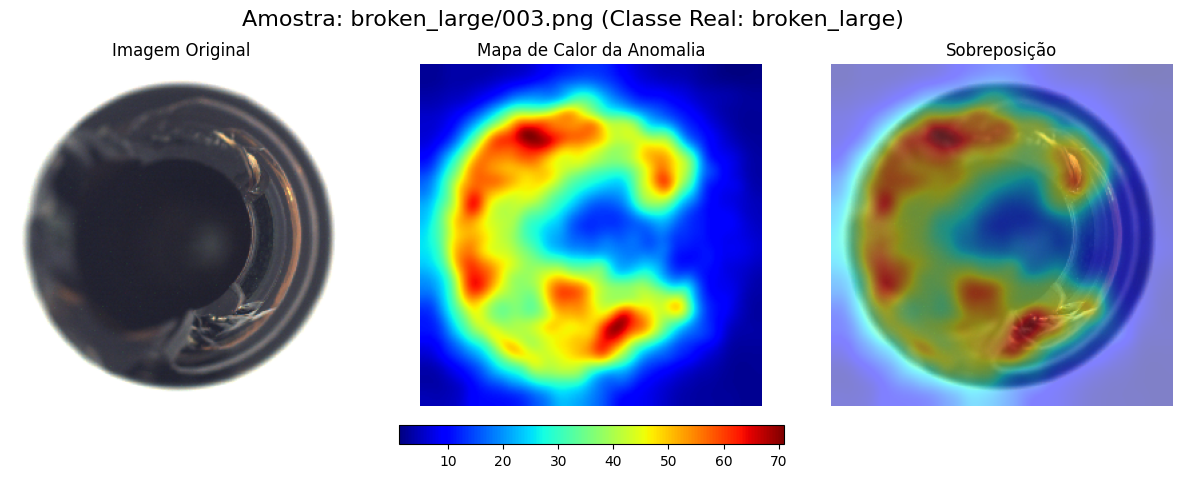

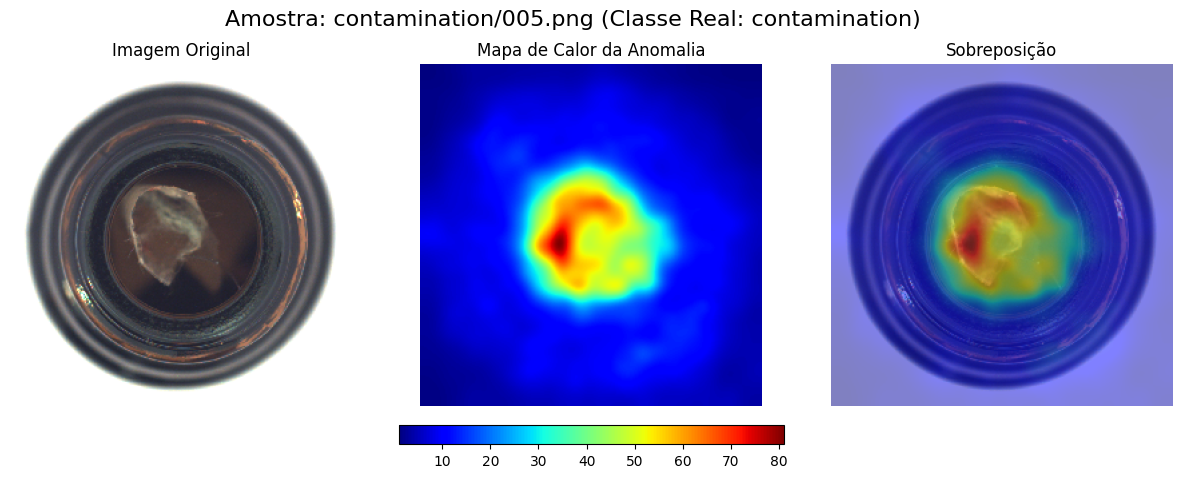

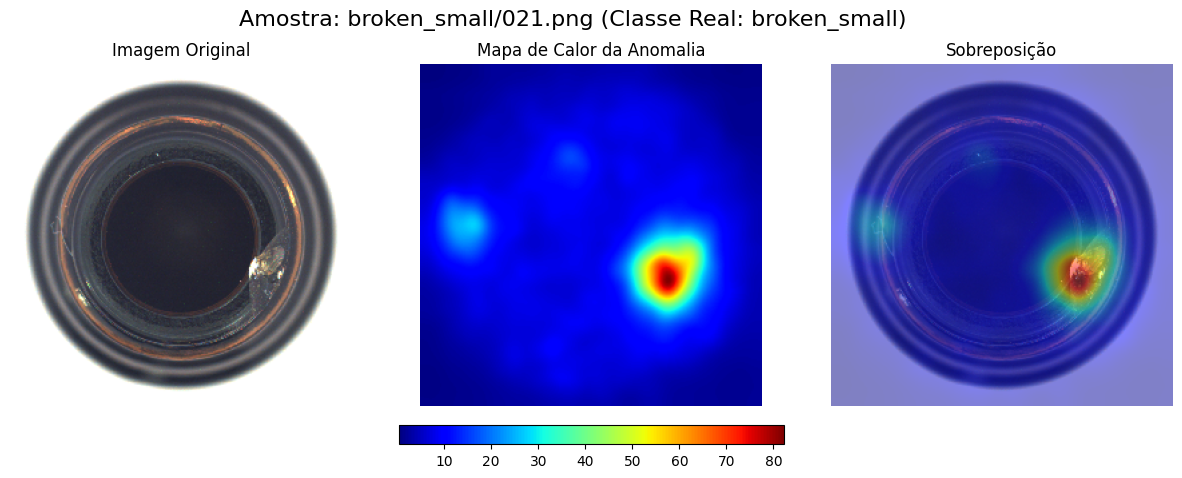

In [9]:
# Célula 7: --- Visualização dos Mapas de Anomalia ---

import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import cv2
import numpy as np

def visualize_padim_results(test_generator, feature_extractor, mean_embeddings, covariance, idx, num_good=3, num_anomaly=3):
    """
    Função para visualizar a imagem original de teste e seu mapa de anomalia,
    mostrando um número específico de amostras 'good' e de anomalia.
    """
    test_generator.reset()
    filenames = test_generator.filenames
    labels = test_generator.classes
    class_indices = test_generator.class_indices

    # Encontrar os índices para cada tipo de classe
    good_indices = np.where(labels == class_indices['good'])[0]
    anomaly_indices = np.where(labels != class_indices['good'])[0]

    # Garantir que não vamos pedir mais amostras do que as disponíveis
    num_good_to_show = min(num_good, len(good_indices))
    num_anomaly_to_show = min(num_anomaly, len(anomaly_indices))

    # Selecionar amostras aleatórias de cada classe (sem reposição)
    selected_good = np.random.choice(good_indices, num_good_to_show, replace=False)
    selected_anomaly = np.random.choice(anomaly_indices, num_anomaly_to_show, replace=False)

    # Combinar os índices para visualização
    indices_to_show = np.concatenate([selected_good, selected_anomaly])

    print(f"\nVisualizando {len(indices_to_show)} mapas de anomalia ({num_good_to_show} da classe 'good' e {num_anomaly_to_show} de anomalias):\n")

    for i in indices_to_show:
        x_test, _ = test_generator[i]
        label = os.path.dirname(filenames[i])

        # Extração de features
        layer1_test, layer2_test, layer3_test = feature_extractor.predict(x_test, verbose=0)
        layer2_resized = tf.image.resize(layer2_test, feature_map_size, method='bilinear')
        layer3_resized = tf.image.resize(layer3_test, feature_map_size, method='bilinear')
        combined_features = np.concatenate([layer1_test, layer2_resized, layer3_resized], axis=-1)
        features_test_reduced = combined_features[:, :, :, idx]

        # Cálculo do mapa de anomalia
        anomaly_map = np.zeros(feature_map_size)
        for h in range(feature_map_size[0]):
            for w in range(feature_map_size[1]):
                feature_vec = features_test_reduced[0, h, w]
                mean_vec = mean_embeddings[h, w]
                cov_mat = covariance[h, w]
                try:
                    L = np.linalg.cholesky(cov_mat)
                    y = np.linalg.solve(L, feature_vec - mean_vec)
                    dist = np.sqrt(np.dot(y, y))
                except np.linalg.LinAlgError:
                    dist = mahalanobis(feature_vec, mean_vec, np.linalg.pinv(cov_mat))
                anomaly_map[h, w] = dist

        # Redimensiona e suaviza o mapa
        anomaly_map_resized = cv2.resize(anomaly_map, IMG_SIZE, interpolation=cv2.INTER_LINEAR)
        anomaly_map_smoothed = gaussian_filter(anomaly_map_resized, sigma=4)

        # Plot
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f"Amostra: {filenames[i]} (Classe Real: {label})", fontsize=16)

        # Imagem Original
        img_to_show = x_test[0].copy()
        img_to_show[:, :, 0] += 103.939
        img_to_show[:, :, 1] += 116.779
        img_to_show[:, :, 2] += 123.68
        img_to_show = img_to_show[:, :, ::-1] # BGR -> RGB
        img_to_show = np.clip(img_to_show, 0, 255).astype('uint8')

        axes[0].imshow(img_to_show)
        axes[0].set_title('Imagem Original')
        axes[0].axis('off')

        im = axes[1].imshow(anomaly_map_smoothed, cmap='jet')
        axes[1].set_title('Mapa de Calor da Anomalia')
        axes[1].axis('off')

        axes[2].imshow(img_to_show)
        axes[2].imshow(anomaly_map_smoothed, cmap='jet', alpha=0.5)
        axes[2].set_title('Sobreposição')
        axes[2].axis('off')

        plt.colorbar(im, ax=axes, orientation='horizontal', pad=0.05, fraction=0.05)
        plt.show()

# Vizualizar 3 amostras 'good' e 3 amostras com anomalia
visualize_padim_results(test_generator, feature_extractor, mean_embeddings, covariance, idx, num_good=3, num_anomaly=3)
